In [1]:
import os; os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import tensorflow as tf

2023-11-20 16:48:16.607832: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
import json
import sys

In [5]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Layer, Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

In [6]:
import matplotlib.pyplot as plt

In [7]:
from koopmanlib.dictionary import PsiNN
from koopmanlib.target import VanderPolMathieuTarget
from koopmanlib.param_solver import KoopmanParametricDLSolver, KoopmanLinearDLSolver, KoopmanBilinearDLSolver

In [8]:
config_file = 'config_vdpm.json'

with open(config_file, 'r') as f:
    config = json.load(f)

data_path = config['data_settings']['data_path']
weights_path = config['nn_settings']['weights_path']

n_traj = config['data_settings']['n_traj']
traj_len = config['data_settings']['traj_len']
mu = config['data_settings']['mu']

n_psi_train = config['nn_settings']['n_psi_train']
dict_layer_size = config['nn_settings']['dict_layer_size']
K_layer_size = config['nn_settings']['K_layer_size']

In [9]:
target_dim = 2
param_dim = 1

n_psi = 1 + target_dim + n_psi_train

In [10]:
# Set parameters in the vdpm equation.
k1, k2, k4, w0 = 2,2,1,1

In [11]:
vdp_mathieu = VanderPolMathieuTarget(mu=mu,
                                     dim=target_dim,
                                     param_dim=param_dim, 
                                     k1=k1,
                                    k2=k2,
                                    k4=k4,
                                    w0=w0)

In [12]:
dic_pk = PsiNN(layer_sizes=dict_layer_size, n_psi_train=n_psi_train)

In [13]:
from koopmanlib.K_structure import Model_K_u_Layer

model_K_u = Model_K_u_Layer(layer_sizes=K_layer_size, 
                                n_psi=n_psi)

solver_pk = KoopmanParametricDLSolver(
    target_dim=target_dim, 
    param_dim=param_dim, 
    n_psi=n_psi, 
    dic=dic_pk, 
    model_K_u=model_K_u)

model_pk, model_K_u_pred_pk = solver_pk.generate_model()

In [14]:
model_pk.load_weights(os.path.join(weights_path, 'model_pk_vdpm_mu_'+str(mu)+'.h5'))

# Linear Model: Dynamics is $Az +Bu$

In [15]:
dic_linear = PsiNN(layer_sizes=dict_layer_size, n_psi_train=n_psi_train)

In [16]:
solver_linear = KoopmanLinearDLSolver(dic=dic_linear, target_dim=target_dim, param_dim=param_dim, n_psi=n_psi)
model_linear = solver_linear.build_model()

In [17]:
model_linear.load_weights(os.path.join(weights_path, 'model_linear_vdpm_mu_'+str(mu)+'.h5'))

# Bilinear Model: Dynamics is $Az + \sum_{i=1}^{N_{u}}B_{i}zu_{i}$

In [18]:
dic_bilinear = PsiNN(layer_sizes=dict_layer_size, n_psi_train=n_psi_train)

In [19]:
solver_bilinear = KoopmanBilinearDLSolver(dic=dic_bilinear, target_dim=target_dim, param_dim=param_dim, n_psi=n_psi)
model_bilinear = solver_bilinear.build_model()

In [20]:
model_bilinear.load_weights(os.path.join(weights_path,'model_bilinear_vdpm_mu_'+str(mu)+'.h5'))

## Prediction

In [21]:
from koopmanlib.functions import *

## Calculate average value

In [22]:
np.random.seed(625)
n_test = 20
seed_x_list = np.random.randint(1,300, size=(n_test,))
seed_param_list = np.random.randint(1,300, size=(n_test,))
n_traj_test = 1
traj_len_test = 50

In [23]:
ratio_pk_list = []
ratio_linear_list = []
ratio_bilinear_list = []

In [24]:
for seed_x, seed_param in zip(seed_x_list, seed_param_list):
    vdp_mathieu_test = VanderPolMathieuTarget(mu=mu,
                                        dim=target_dim,
                                        param_dim=param_dim,
                                        k1=k1,
                                        k2=k2,
                                        k4=k4,
                                        w0=w0)
    
    
    data_x_test, data_u_test = vdp_mathieu_test.generate_init_data(n_traj=n_traj_test,
                                                                   traj_len=traj_len_test,
                                                                  seed_x=seed_x,
                                                                  seed_param=seed_param)
    data_x_init = tf.reshape(data_x_test[0], shape=(1,-1))
    data_true = data_x_test
    
    data_pred_list_pk= solver_pk.compute_data_list(
                                     traj_len_test,
                                     data_x_init,
                                     data_u_test)
    data_pred_list_linear= solver_linear.compute_data_list(
                                                     traj_len=traj_len_test, 
                                                     data_x_init=data_x_init, 
                                                     data_u=data_u_test)
    data_pred_list_bilinear= solver_bilinear.compute_data_list(
                                                     traj_len=traj_len_test, 
                                                     data_x_init=data_x_init, 
                                                     data_u=data_u_test)
    
    ratio_pk = compute_diff_ratio_one_traj(data_true, 
                                    data_pred_list_pk)
    ratio_linear = compute_diff_ratio_one_traj(data_true, 
                                        data_pred_list_linear)
    ratio_bilinear = compute_diff_ratio_one_traj(data_true, 
                                        data_pred_list_bilinear)
    
    
    ratio_pk_list.append(ratio_pk)
    ratio_linear_list.append(ratio_linear)
    ratio_bilinear_list.append(ratio_bilinear)
    

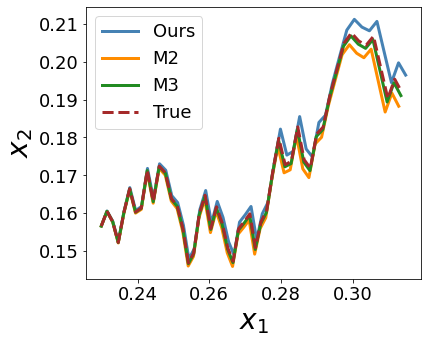

In [25]:
plt.figure(figsize=(6,5))
plt.plot(data_pred_list_pk[:,0], data_pred_list_pk[:,1], label='Ours', color='steelblue', linewidth=3)
plt.plot(data_pred_list_linear[:,0], data_pred_list_linear[:,1], label='M2', color='darkorange', linewidth=3)
plt.plot(data_pred_list_bilinear[:,0], data_pred_list_bilinear[:,1], label='M3', color='forestgreen', linewidth=3)
plt.plot(data_true[:,0], data_true[:,1], label='True', color='brown', linestyle='dashed', linewidth=3)
plt.xlabel(r'$x_{1}$', fontsize=28)
plt.ylabel(r'$x_{2}$', fontsize=28)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)

In [26]:
ratio_pk_list = np.asarray(ratio_pk_list)
ratio_linear_list = np.asarray(ratio_linear_list)
ratio_bilinear_list = np.asarray(ratio_bilinear_list)

In [27]:
ratio_pk_list_mean = np.mean(ratio_pk_list, axis=0)
ratio_linear_list_mean = np.mean(ratio_linear_list, axis=0)
ratio_bilinear_list_mean = np.mean(ratio_bilinear_list, axis=0)

In [28]:
ratio_pk_list_median = np.median(ratio_pk_list, axis=0)
ratio_linear_list_median = np.median(ratio_linear_list, axis=0)
ratio_bilinear_list_median = np.median(ratio_bilinear_list, axis=0)

In [29]:
q_min = 0.35
q_max = 0.65

In [30]:
ratio_pk_list_min = np.quantile(ratio_pk_list, q=q_min, axis=0)
ratio_linear_list_min = np.quantile(ratio_linear_list, q=q_min, axis=0)
ratio_bilinear_list_min = np.quantile(ratio_bilinear_list, q=q_min, axis=0)

In [31]:
ratio_pk_list_max = np.quantile(ratio_pk_list, q=q_max, axis=0)
ratio_linear_list_max = np.quantile(ratio_linear_list, q=q_max, axis=0)
ratio_bilinear_list_max = np.quantile(ratio_bilinear_list, q=q_max, axis=0)

In [32]:
x_axis = np.arange(0,50,1)

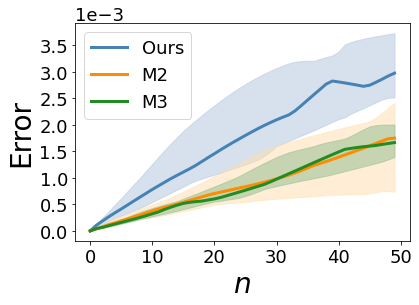

In [33]:
plt.figure(figsize=(6,4))

plt.plot(ratio_pk_list_median, label='Ours', color='steelblue', linewidth=3)
plt.fill_between(x_axis, ratio_pk_list_min, ratio_pk_list_max, color='lightsteelblue', alpha=0.5)
plt.plot(ratio_linear_list_median, label='M2', color='darkorange', linewidth=3)
plt.fill_between(x_axis, ratio_linear_list_min, ratio_linear_list_max, color='navajowhite', alpha=0.5)
plt.plot(ratio_bilinear_list_median, label='M3', color='forestgreen', linewidth=3)
plt.fill_between(x_axis, ratio_bilinear_list_min, ratio_bilinear_list_max, color='darkseagreen', alpha=0.5)


plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.gca().yaxis.get_offset_text().set_fontsize(18)

plt.xlabel(r'$n$', fontsize=28)
plt.ylabel('Error', fontsize=28)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)


In [50]:
dict_mean = {'pk': ratio_pk_list_mean,
              'linear': ratio_linear_list_mean,
              'bilinear': ratio_bilinear_list_mean}

In [51]:
np.save(os.path.join(data_path, 'ratio_list_dict_mu_'+str(mu)+'_mean.npy'), dict_mean)

# See the comparison
If you have tested on all $mu: 0,1,2,3,4$, then you can run the following codes to see the comparison.

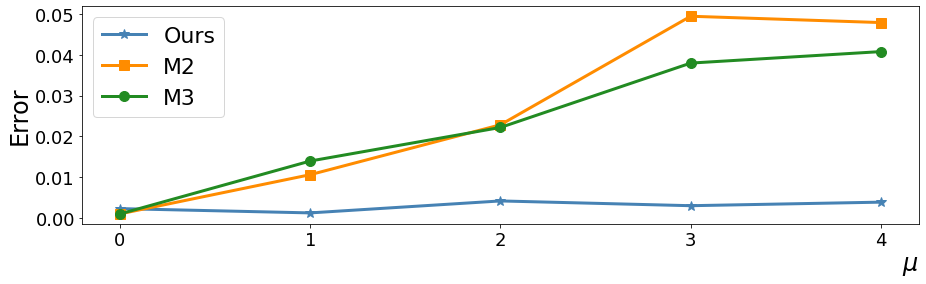

In [53]:
import numpy as np

import matplotlib.pyplot as plt

mean_dict_mu_0 = np.load(os.path.join(data_path, 'ratio_list_dict_mu_0_mean.npy'), allow_pickle=True)
mean_dict_mu_1 = np.load(os.path.join(data_path, 'ratio_list_dict_mu_1_mean.npy'), allow_pickle=True)
mean_dict_mu_2 = np.load(os.path.join(data_path, 'ratio_list_dict_mu_2_mean.npy'), allow_pickle=True)
mean_dict_mu_3 = np.load(os.path.join(data_path, 'ratio_list_dict_mu_3_mean.npy'), allow_pickle=True)
mean_dict_mu_4 = np.load(os.path.join(data_path, 'ratio_list_dict_mu_4_mean.npy'), allow_pickle=True)

def extact_data(ratio_dict, ratio_name):
    ratio_pk = ratio_dict[()][ratio_name[0]].reshape((1,-1))
    ratio_linear = ratio_dict[()][ratio_name[1]].reshape((1,-1))
    ratio_bilinear = ratio_dict[()][ratio_name[2]].reshape((1,-1))
    return ratio_pk, ratio_linear, ratio_bilinear

mean_dict_list = [mean_dict_mu_0, mean_dict_mu_1, mean_dict_mu_2, mean_dict_mu_3, mean_dict_mu_4]

ratio_pk_list = []
ratio_linear_list = []
ratio_bilinear_list = []

ratio_name_list = ['pk', 'linear', 'bilinear']

def concat_ratio_list(ratio_list):
    ratio_concat = np.concatenate(ratio_list, axis=0)
    ratio_concat = ratio_concat.T
    return ratio_concat

def concat_data(dict_list):
    pk_list=[]
    linear_list = []
    bilinear_list = []

    for i in range(5):
        pk, linear, bilinear = extact_data(dict_list[i], ratio_name=ratio_name_list)
        pk_list.append(pk)
        linear_list.append(linear)
        bilinear_list.append(bilinear)
        
    pk_concat = concat_ratio_list(pk_list)
    linear_concat = concat_ratio_list(linear_list)
    bilinear_concat = concat_ratio_list(bilinear_list)
    
    return pk_concat, linear_concat, bilinear_concat

mean_pk, mean_linear, mean_bilinear = concat_data(mean_dict_list)

mean_linear_mean = np.mean(mean_linear, axis=0)
mean_bilinear_mean = np.mean(mean_bilinear, axis=0)
mean_pk_mean = np.mean(mean_pk, axis=0)

mu = [0,1,2,3,4]
mu_axis = list(range(len(mu)))


def plot_evaluate_vdpm(mu, mean, dict_plot):
    plt.plot(mu,
             mean,
             label=dict_plot['label'],
             marker=dict_plot['marker'], 
             markersize=dict_plot['markersize'], 
             color=dict_plot['color'],
             linestyle=dict_plot['linestyle'],
             linewidth=dict_plot['linewidth'])

label_font = 24
ticks_font = 18
legend_font = 22






dict_plot_pk = {'label':'Ours',
                'marker':'*',
                'markersize':10,
                'color':'steelblue',
                'linestyle':'-',
                'linewidth':3
               }

dict_plot_linear = {'label':'M2',
                'marker':'s',
                'markersize':10,
                'color':'darkorange',
                'linestyle':'-',
                'linewidth':3
               }

dict_plot_bilinear = {'label':'M3',
                'marker':'o',
                'markersize':10,
                'color':'forestgreen',
                'linestyle':'-',
                'linewidth':3
               }

plt.figure(figsize=(15,4))
plot_evaluate_vdpm(mu, mean_pk_mean, dict_plot=dict_plot_pk)
plot_evaluate_vdpm(mu, mean_linear_mean, dict_plot=dict_plot_linear)

plot_evaluate_vdpm(mu, mean_bilinear_mean, dict_plot=dict_plot_bilinear)

plt.xlabel(r'$\mu$', loc='right', fontsize=label_font)
plt.ylabel('Error', fontsize=label_font)
plt.xticks(mu_axis, mu, fontsize=ticks_font)
plt.yticks(fontsize=ticks_font)
plt.legend(fontsize=legend_font)
